In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import pathlib

PROJECT_ROOT = pathlib.Path().cwd().parent
sys.path.append(str(PROJECT_ROOT))

from src.settings import Config
from src.utils import Network, Results, FineNetwork, CoarseNetwork
from src.models import SpatialAggregation, TemporalAggregation
from src.visualization import Visualizer
from src.main import StaticPreprocessor, DynamicProcessor
from src.gtep import read_data, GTEPBase, AggregatedGTEP, SpatialGTEP, TemporalGTEP

import pickle
import xarray as xr
import numpy as np
from numba import njit, prange
import pandas as pd
import matplotlib.pyplot as plt
import time
import gurobipy as gp
from gurobipy import GRB

# Full pipeline

In [3]:
# Static preprocessing (run once)
static_prep = StaticPreprocessor(granularity="coarse").preprocess()

# Dynamic processor (reused for multiple runs)
processor = DynamicProcessor(static_prep)

res, version_hash, day_weights, res_meta = processor.run_with_hyperparameters(
    weights={
        'position': 1.0,
        'time_series': 0.8,
        'duration_curves': 1.2,
        'ramp_duration_curves': 1.0,
        'intra_correlation': 1.0,
        'inter_correlation': 1.0
    },
    n_representative_nodes=5,
    k_representative_days=7
)

# # Define parameter grid
# param_grid = {
#     'weights': [
#         {'position': 1.0, 'time_series': 0.8, 'duration_curves': 1.2},
#         {'position': 0.8, 'time_series': 1.0, 'duration_curves': 1.0}
#     ],
#     'n_representative_nodes': [10, 15],
#     'k_representative_days': [8, 10]
# }

# # Execute grid search
# results = {}
# for params in ParameterGrid(param_grid):
#     res, version_hash = processor.run_with_hyperparameters(
#         weights=params['weights'],
#         n_representative_nodes=params['n_representative_nodes'],
#         k_representative_days=params['k_representative_days']
#     )
#     results[version_hash] = {'params': params, 'results': res}

c:\Users\g630d\Documents\00_Cours\2024-2025_MIT\00 Thesis\dev\src\utils.py:143: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  counties.geometry.centroid.y,
c:\Users\g630d\Documents\00_Cours\2024-2025_MIT\00 Thesis\dev\src\utils.py:144: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  counties.geometry.centroid.x


Cached metrics loaded from c:\Users\g630d\Documents\00_Cours\2024-2025_MIT\00 Thesis\dev\results\distance_metrics\v202586c2.
Results saved to c:\Users\g630d\Documents\00_Cours\2024-2025_MIT\00 Thesis\dev\results\joint_aggregation_results\vc24b4116


In [13]:
processor.preprocessor.network_data["nodes"]

,Lat,Lon
0,42.642711,-70.865107
1,42.479477,-71.396507
2,42.331960,-71.020173
3,42.169703,-71.179875
4,41.644282,-70.576707
5,42.311693,-71.940282
6,42.358691,-72.776236
7,44.958418,-69.250412
8,43.829991,-70.263051
9,44.161374,-72.685273


In [4]:
def data_cb(model, where):
    if where == gp.GRB.Callback.MIP:
        cur_obj = model.cbGet(gp.GRB.Callback.MIP_OBJBST)
        cur_bd = model.cbGet(gp.GRB.Callback.MIP_OBJBND)

        # Did objective value or best bound change?
        if model._obj != cur_obj or model._bd != cur_bd:
            model._obj = cur_obj
            model._bd = cur_bd
            model._data.append([time.time() - model._start, cur_obj, cur_bd])
            pd.DataFrame(model._data).to_csv('full_solve_log.csv')

def run_agg_gtep(agg_results, day_weights):
    """
    Run the GTEP model with the provided aggregated results and representative days weights.
    """
    # Read data from the aggregated results
    buses, branches, load, pv, wind, params = read_data(agg_results["spatiotemporal"])
    day_weigths_list = list(day_weights.values())

    data = [buses, branches]
    eval_period = {'Load': load, 'PV': pv, 'Wind': wind}
    for key in ['c_ccgt', 'c_pv', 'c_wind', 'c_stor_energy', 'c_stor_power', 'c_tran', 'd_ccgt', 'd_shed']:
        params[key] = params[key] * 1e-5

    with gp.Env(empty=True) as env:
        env.setParam('OutputFlag', 1)
        env.start()

        gtep = AggregatedGTEP(env, data, params)
        gtep.model._obj = None
        gtep.model._bd = None
        gtep.model._data = []
        gtep.model._start = time.time()
        cep_results = gtep.solve(eval_period, day_weigths_list, callback=data_cb)

        return cep_results, params

def run_spatial_gtep(agg_results, day_weights, aggregated_gtep_results, sptial_agg_results):
    """
    Run the Spatial GTEP model with the provided aggregated results and representative days weights.
    """
    buses, branches, load, pv, wind, params = read_data(agg_results["temporal_only"])
    day_weigths_list = list(day_weights.values())

    data = [buses, branches]
    eval_period = {'Load': load, 'PV': pv, 'Wind': wind}
    for key in ['c_ccgt', 'c_pv', 'c_wind', 'c_stor_energy', 'c_stor_power', 'c_tran', 'd_ccgt', 'd_shed']:
        params[key] = params[key] * 1e-5

    with gp.Env(empty=True) as env:
        env.setParam('OutputFlag', 1)
        env.start()

        gtep = SpatialGTEP(env, data, params, aggregated_gtep_results, sptial_agg_results, agg_results["spatiotemporal"]["branches"])
        gtep.model._obj = None
        gtep.model._bd = None
        gtep.model._data = []
        gtep.model._start = time.time()
        cep_results = gtep.solve(eval_period, day_weigths_list, callback=data_cb)

        return cep_results, params
    
def run_temporal_gtep(agg_results, investment_results):
    """
    Run the Temporal GTEP model with the provided aggregated results and representative days weights.
    """
    buses, branches, load, pv, wind, params = read_data(agg_results["original"])

    data = [buses, branches]
    eval_period = {'Load': load, 'PV': pv, 'Wind': wind}
    for key in ['c_ccgt', 'c_pv', 'c_wind', 'c_stor_energy', 'c_stor_power', 'c_tran', 'd_ccgt', 'd_shed']:
        params[key] = params[key] * 1e-5

    with gp.Env(empty=True) as env:
        env.setParam('OutputFlag', 1)
        env.start()

        gtep = TemporalGTEP(env, data, params, investment_results)
        gtep.model._obj = None
        gtep.model._bd = None
        gtep.model._data = []
        gtep.model._start = time.time()
        number_of_days = len(eval_period['Load']) // 24
        day_weights = [1/number_of_days]*number_of_days
        cep_results = gtep.solve(eval_period, day_weights, callback=data_cb)

        return cep_results, params

In [5]:
agg_cep_results, agg_params = run_agg_gtep(res, day_weights)

PV shape  (168, 5)
Wind shape  (168, 5)
Load shape  (168, 5)
Data loaded successfully.
Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-06
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 19179 rows, 8445 columns and 51373 nonzeros
Model fingerprint: 0xfa6b14e0
Variable types: 8440 continuous, 5 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e-04, 1e+03]
  Objective range  [7e-03, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+02, 5e+05]
Presolve removed 5564 rows and 4445 columns
Presolve time: 0.06s
Presolved: 13615 rows, 4000 columns, 37500 nonzeros
Variable types: 3995 continuous, 5 integer (0 binary)

Root relaxation: objective 2.276122e+04, 27636 iterations, 4.43 seconds (5.22 work units)

  

In [16]:
save_cep_results(agg_cep_results, agg_params, version_hash, 1)

CEP results saved to c:\Users\g630d\Documents\00_Cours\2024-2025_MIT\00 Thesis\dev\results\cep_output\agg_cep_results_c24b4116.pkl


In [10]:
agg_demand = res["spatiotemporal"]["time_series"]["demand"]
demand = res["temporal_only"]["time_series"]["demand"]
for rep_id, members in res_meta["spatial_clusters"]["clusters"].items():
    summed = demand[members].sum(axis=1)
    if not np.allclose(summed, agg_demand[rep_id]):
        print(f"Mismatch in demand for representative node {rep_id}:")
        print(f"Aggregated: {agg_demand[rep_id]}")
        print(f"Summed: {summed}")
    else:
        print(f"Demand for representative node {rep_id} matches aggregated value.")

Demand for representative node 0 matches aggregated value.
Demand for representative node 2 matches aggregated value.
Demand for representative node 5 matches aggregated value.
Demand for representative node 9 matches aggregated value.
Demand for representative node 13 matches aggregated value.


In [23]:
spatially_deaggregated_results, spatial_params = run_spatial_gtep(res, day_weights, agg_cep_results["inv"], res_meta["spatial_clusters"])

[autoreload of src.gtep failed: Traceback (most recent call last):
  File "c:\Users\g630d\anaconda3\Lib\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\g630d\anaconda3\Lib\site-packages\IPython\extensions\autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "c:\Users\g630d\anaconda3\Lib\site-packages\IPython\extensions\autoreload.py", line 397, in update_generic
    update(a, b)
  File "c:\Users\g630d\anaconda3\Lib\site-packages\IPython\extensions\autoreload.py", line 365, in update_class
    update_instances(old, new)
  File "c:\Users\g630d\anaconda3\Lib\site-packages\IPython\extensions\autoreload.py", line 322, in update_instances
    if type(ref) is old:
       ^^^^^^^^^^^^^^^^
KeyboardInterrupt
]


PV shape  (168, 17)
Wind shape  (168, 17)
Load shape  (168, 17)
Data loaded successfully.
Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-06
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 168647 rows, 63189 columns and 483846 nonzeros
Model fingerprint: 0x5738e520
Variable types: 63172 continuous, 17 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e-04, 2e+03]
  Objective range  [7e-03, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+05]
Found heuristic solution: objective 7657545.4301
Presolve removed 37412 rows and 31427 columns
Presolve time: 2.69s
Presolved: 131235 rows, 31762 columns, 348511 nonzeros
Variable types: 31747 continuous, 15 integer (1 binary)

Deterministic concurrent LP o

In [17]:
save_cep_results(spatially_deaggregated_results, spatial_params, version_hash, 2)

CEP results saved to c:\Users\g630d\Documents\00_Cours\2024-2025_MIT\00 Thesis\dev\results\cep_output\spatial_cep_results_c24b4116.pkl


In [9]:
spatially_deaggregated_results, spatial_params = load_cep_results(version_hash, 2)

CEP results loaded from c:\Users\g630d\Documents\00_Cours\2024-2025_MIT\00 Thesis\dev\results\cep_output\spatial_cep_results_c24b4116.pkl


In [24]:
temporal_cep_results, temporal_params = run_temporal_gtep(res, spatially_deaggregated_results["inv"])
save_cep_results(temporal_cep_results, temporal_params, version_hash, 3)

PV shape  (8760, 17)
Wind shape  (8760, 17)
Load shape  (8760, 17)
Data loaded successfully.
Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-06
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 8777811 rows, 3276597 columns and 25211563 nonzeros
Model fingerprint: 0xb564d61e
Variable types: 3276580 continuous, 17 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e-04, 2e+03]
  Objective range  [5e-07, 1e+02]
  Bounds range     [1e+00, 1e+04]
  RHS range        [2e+02, 5e+05]
Presolve removed 0 rows and 0 columns (presolve time = 6s) ...
Presolve removed 5668011 rows and 289420 columns (presolve time = 10s) ...
Presolve removed 5668011 rows and 306940 columns
Presolve time: 14.99s

Explored 0 nodes (0 simplex iteration

GurobiError: Out of memory

In [18]:
buses, branches, load, pv, wind, params = read_data(res["original"])
eval_period = {'Load': load, 'PV': pv, 'Wind': wind}
number_of_days = len(eval_period['Load']) // 24
weights = [1/number_of_days]*number_of_days
for i in range(len(weights)):
    print(f"Running GTEP for hour {i} with weight {weights[i]}")
    for t in range(24*i,24*(i+1)):
        print(f"Weight for hour {t}: {weights[i]}")

PV shape  (8760, 17)
Wind shape  (8760, 17)
Load shape  (8760, 17)
Data loaded successfully.
Running GTEP for hour 0 with weight 0.0027397260273972603
Weight for hour 0: 0.0027397260273972603
Weight for hour 1: 0.0027397260273972603
Weight for hour 2: 0.0027397260273972603
Weight for hour 3: 0.0027397260273972603
Weight for hour 4: 0.0027397260273972603
Weight for hour 5: 0.0027397260273972603
Weight for hour 6: 0.0027397260273972603
Weight for hour 7: 0.0027397260273972603
Weight for hour 8: 0.0027397260273972603
Weight for hour 9: 0.0027397260273972603
Weight for hour 10: 0.0027397260273972603
Weight for hour 11: 0.0027397260273972603
Weight for hour 12: 0.0027397260273972603
Weight for hour 13: 0.0027397260273972603
Weight for hour 14: 0.0027397260273972603
Weight for hour 15: 0.0027397260273972603
Weight for hour 16: 0.0027397260273972603
Weight for hour 17: 0.0027397260273972603
Weight for hour 18: 0.0027397260273972603
Weight for hour 19: 0.0027397260273972603
Weight for hour 20:

In [ ]:
res_meta["spatial_clusters"]

dict_keys(['clusters', 'representatives', 'metadata'])

In [ ]:
# On HPC, you might want:
model.setParam('Threads', 48)        # Use all cores
model.setParam('Method', 0)  # Primal simplex only - the winner!
# model.setParam('NodeMethod', 1)      # Dual simplex for nodes too

In [ ]:
def run_gtep(agg_results, day_weights, gtepsolver=):
    """
    Run the GTEP model with the provided aggregated results and representative days weights.
    """
    # Read data from the aggregated results
    buses, branches, load, pv, wind, params = read_data(agg_results)
    day_weigths_list = list(day_weights.values())

    data = [buses, branches]
    eval_period = {'Load': load, 'PV': pv, 'Wind': wind}
    for key in ['c_ccgt', 'c_pv', 'c_wind', 'c_stor_energy', 'c_stor_power', 'c_tran', 'd_ccgt', 'd_shed']:
        params[key] = params[key] * 1e-5

    with gp.Env(empty=True) as env:
        env.setParam('OutputFlag', 1)
        env.start()

        gtep = GTEP(env, data, params)
        gtep.model._obj = None
        gtep.model._bd = None
        gtep.model._data = []
        gtep.model._start = time.time()
        cep_results = gtep.solve(eval_period, day_weigths_list, callback=data_cb)

        return cep_results, params

In [30]:
# spatiotemporal temporal_only original
res["spatiotemporal"]["time_series"]["demand"]

,39,44,79,122,164,192,196,292,310,359
336,2330.031796,4983.933282,5116.645908,1196.257575,410.912679,119.475089,827.436830,191.007354,68.908938,77.694980
337,2188.343896,4680.863153,4805.505600,1123.513837,385.925314,112.209877,777.120870,179.392306,64.718625,72.970393
338,2112.117777,4517.815638,4638.116441,1084.378717,372.482460,108.301294,750.051584,173.143572,62.464295,70.428631
339,2074.328188,4436.983784,4555.132189,1064.977230,365.818078,106.363589,736.631811,170.045722,61.346696,69.168536
340,2041.699514,4367.191117,4483.481076,1048.225399,360.063849,104.690516,725.044773,167.370944,60.381728,68.080532
...,...,...,...,...,...,...,...,...,...,...
7579,2331.127162,4986.276269,5119.051284,1196.819945,411.105853,119.531255,827.825815,191.097148,68.941333,77.731505
7580,2323.597117,4970.169518,5102.515641,1192.953958,409.777892,119.145143,825.151758,190.479863,68.718638,77.480416
7581,2299.458942,4918.538011,5049.509285,1180.561219,405.521005,117.907430,816.579852,188.501105,68.004769,76.675527
7582,2176.084015,4654.639291,4778.583447,1117.219512,383.763224,111.581237,772.767163,178.387287,64.356049,72.561587


In [ ]:
cep_results, params = run_gtep(res["spatiotemporal"], day_weights)

In [6]:
def save_cep_results(cep_results, params, version_hash, tag):
    """
    Save the CEP results and parameters to a file.
    """
    if tag == 1:
        name_cep_results = 'agg_cep_results'
    elif tag == 2:
        name_cep_results = 'spatial_cep_results'
    elif tag == 3:
        name_cep_results = 'temporal_cep_results'
    output_path = PROJECT_ROOT / 'results' / 'cep_output' / f'{name_cep_results}_{version_hash}.pkl'
    with open(output_path, 'wb') as f:
        pickle.dump({'results': cep_results, 'params': params}, f)
    print(f"CEP results saved to {output_path}")

def load_cep_results(version_hash, tag):
    """
    Load the CEP results and parameters from a file.
    """
    if tag == 1:
        name_cep_results = 'agg_cep_results'
    elif tag == 2:
        name_cep_results = 'spatial_cep_results'
    elif tag == 3:
        name_cep_results = 'temporal_cep_results'
    input_path = PROJECT_ROOT / 'results' / 'cep_output' / f'{name_cep_results}_{version_hash}.pkl'
    with open(input_path, 'rb') as f:
        data = pickle.load(f)
    print(f"CEP results loaded from {input_path}")
    return data['results'], data['params']

In [ ]:
save_cep_results(cep_results, params, version_hash)

CEP results saved to c:\Users\g630d\Documents\00_Cours\2024-2025_MIT\00 Thesis\dev\results\cep_output\cep_results_85c39199.pkl


In [10]:
cep_results, params = load_cep_results(version_hash)

CEP results loaded from c:\Users\g630d\Documents\00_Cours\2024-2025_MIT\00 Thesis\dev\results\cep_output\cep_results_85c39199.pkl


In [32]:
cep_results["inv"]["Tran"]

[autoreload of src.gtep failed: Traceback (most recent call last):
  File "c:\Users\g630d\anaconda3\Lib\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\g630d\anaconda3\Lib\site-packages\IPython\extensions\autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "c:\Users\g630d\anaconda3\Lib\importlib\__init__.py", line 131, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 866, in _exec
  File "<frozen importlib._bootstrap_external>", line 991, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1129, in get_code
  File "<frozen importlib._bootstrap_external>", line 1059, in source_to_code
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "c:\Users\g630d\Documents\00_Cours\2024-2025_MIT\00 Thesis\dev\src\gtep.py", line 196
    for 
        ^
SyntaxError: invalid synta

{0: 182.701,
 1: 59.978,
 2: 25.786,
 3: 38.806,
 4: 18.304,
 5: 20.532,
 6: 21.396,
 7: 22.774,
 8: 17.274,
 9: 182.701,
 10: 207.285,
 11: 73.588,
 12: 48.148,
 13: 50.307,
 14: 52.017,
 15: 42.63,
 16: 43.549,
 17: 31.672,
 18: 59.978,
 19: 207.285,
 20: 33.336,
 21: 30.654,
 22: 12.232,
 23: 14.844,
 24: 18.572,
 25: 20.312,
 26: 14.579,
 27: 25.786,
 28: 73.588,
 29: 33.336,
 30: 73.464,
 31: 17.241,
 32: 19.312,
 33: 20.79,
 34: 25.268,
 35: 16.671,
 36: 38.806,
 37: 48.148,
 38: 30.654,
 39: 73.464,
 40: 40.113,
 41: 27.722,
 42: 18.875,
 43: 25.641,
 44: 14.064,
 45: 18.304,
 46: 50.307,
 47: 12.232,
 48: 17.241,
 49: 40.113,
 50: 43.863,
 51: 31.648,
 52: 43.162,
 53: 23.402,
 54: 20.532,
 55: 52.017,
 56: 14.844,
 57: 19.312,
 58: 27.722,
 59: 43.863,
 60: 39.249,
 61: 47.633,
 62: 26.459,
 63: 21.396,
 64: 42.63,
 65: 18.572,
 66: 20.79,
 67: 18.875,
 68: 31.648,
 69: 39.249,
 70: 29.197,
 71: 27.756,
 72: 22.774,
 73: 43.549,
 74: 20.312,
 75: 25.268,
 76: 25.641,
 77: 43.1

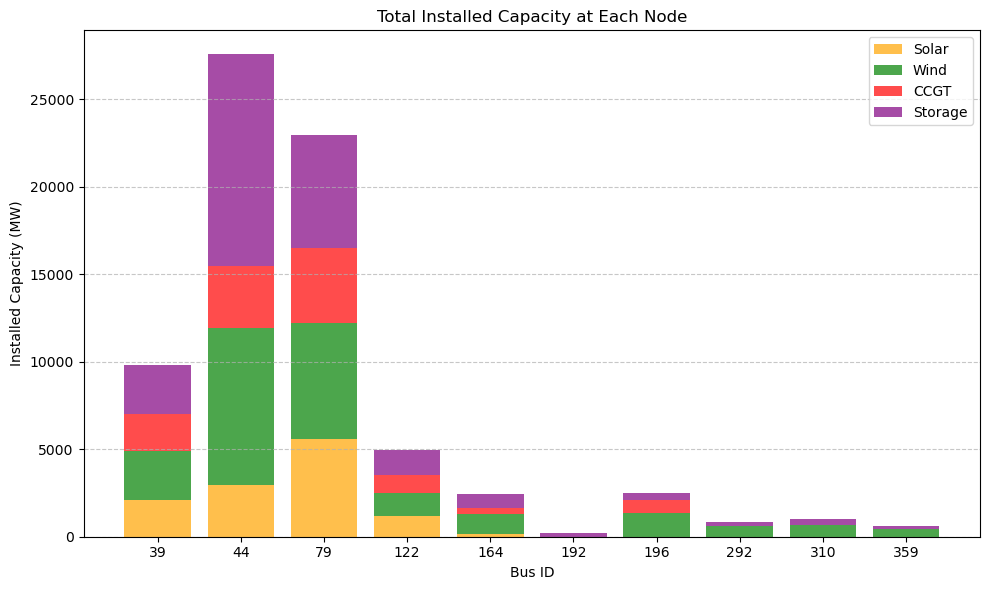

In [11]:
# Extract investments from the loaded results
pv_investment = np.array(list(cep_results["inv"]["PV"].values()))
wind_investment = np.array(list(cep_results["inv"]["Wind"].values()))
ccgt_investment = np.array(list(cep_results["inv"]["CCGT"].values())) * params['CCGT Max Cap']
storage_investment = np.array(list(cep_results["inv"]["Storage Energy"].values()))

bus_ids = list(cep_results["inv"]["PV"].keys())
x = np.arange(len(bus_ids))  # positions for bars

plt.figure(figsize=(10, 6))

plt.bar(x, pv_investment, color='orange', label='Solar', alpha=0.7)
plt.bar(x, wind_investment, bottom=pv_investment, color='green', label='Wind', alpha=0.7)
plt.bar(x, ccgt_investment, bottom=pv_investment + wind_investment, color='red', label='CCGT', alpha=0.7)
plt.bar(x, storage_investment, bottom=pv_investment + wind_investment + ccgt_investment, color='purple', label='Storage', alpha=0.7)

plt.xlabel('Bus ID')
plt.ylabel('Installed Capacity (MW)')
plt.title('Total Installed Capacity at Each Node')
plt.xticks(x, bus_ids, rotation=0)  # Use bus_ids as labels, no extra space
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('installed_capacity.png', dpi=300)
plt.show()